In [3]:
import calc_footprint_FFP_climatology as myfootprint_s
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import xarray as xr
import shapefile
import rasterio
#import cv2
from affine import Affine
from osgeo import gdal
import pygeodesy
import pyproj as proj
import cartopy.crs as ccrs
import traceback
import os
import datetime as dt
import scipy

In [4]:
in_dir = '/Users/miksch/Thesis_Files/Processed/Eagle_Lake/EL_eb/'
sigv_2017 = os.path.join(in_dir,'ls8_var_2017.csv')
sigv_2018 = os.path.join(in_dir,'ls8_var_2018.csv')
fluxes = os.path.join(in_dir,'ls8_flux.csv')

def date_parse(yr,doy,hr):
    if '2400' in hr:
        hr = '000'
        return pd.datetime.strptime(f'{yr}{int(doy)+1}{int(hr):04}', '%Y%j%H%M')
    else:
        return pd.datetime.strptime(f'{yr}{doy}{int(hr):04}', '%Y%j%H%M')
    
def date_parse_sigv_17(doy,hr):
    yr='2017'
    if '2400' in hr:
        hr = '000'
        return pd.datetime.strptime(f'{yr}{int(doy)+1}{int(hr):04}', '%Y%j%H%M')
    else:
        return pd.datetime.strptime(f'{yr}{doy}{int(hr):04}', '%Y%j%H%M')


def date_parse_sigv_18(doy,hr):
    yr='2018'
    if '2400' in hr:
        hr = '000'
        return pd.datetime.strptime(f'{yr}{int(doy)+1}{int(hr):04}', '%Y%j%H%M')
    else:
        return pd.datetime.strptime(f'{yr}{doy}{int(hr):04}', '%Y%j%H%M')

flux_df = pd.read_csv(fluxes,delim_whitespace=True,parse_dates={'TIMESTAMP':[0,1,2]},date_parser=date_parse,
                      index_col=0,na_values=['*****'])

sigv_df_2017 = pd.read_csv(sigv_2017,delim_whitespace=True,parse_dates={'TIMESTAMP':[0,1]}, date_parser=date_parse_sigv_17,
                           index_col=0,names=['DOY','hrmin','mag_v','sig_v'])
sigv_df_2018 = pd.read_csv(sigv_2018,delim_whitespace=True,parse_dates={'TIMESTAMP':[0,1]}, date_parser=date_parse_sigv_18,
                           index_col=0,names=['DOY','hrmin','mag_v','sig_v'])

sigv_df = pd.concat([sigv_df_2017,sigv_df_2018])
full_df = pd.concat([flux_df,sigv_df],axis=1)
full_df = full_df[full_df.index.hour == 12]
full_df.to_csv('filtered_footprint_inputs.csv')
ls8 = xr.open_dataset('/Users/miksch/Thesis_Files/Processed/landsat/EL_LS8/ls8_v02.nc')

2017-05-19 12:00:00
'2017-05-19'
2017-06-04 12:00:00
0.686378502741842
2017-06-20 12:00:00
0.6982272246785379
2017-07-06 12:00:00
0.8974237826728484
2017-07-22 12:00:00
0.7191104022678051
2017-08-07 12:00:00
0.6936219729594246
2017-08-23 12:00:00
0.9952217472867594
2017-09-08 12:00:00
1.051570318301559
2017-10-10 12:00:00
0.7745889533456053
2017-10-26 12:00:00
0.6417728765347164
2018-05-06 12:00:00
0.7046253759899577
2018-05-22 12:00:00
Buffer has wrong number of dimensions (expected 2, got 1)
2018-06-07 12:00:00
0.7152465906597212
2018-06-23 12:00:00
0.6865761833792604
2018-07-09 12:00:00
0.7580939394134208
2018-07-25 12:00:00
0.6786577763482006
2018-08-10 12:00:00
0.6607014811355801
2018-08-26 12:00:00
Buffer has wrong number of dimensions (expected 2, got 1)
2018-09-11 12:00:00
0.7816969201007259
2018-09-27 12:00:00
0.7410598311765406
2018-10-13 12:00:00
0.7371309861884553


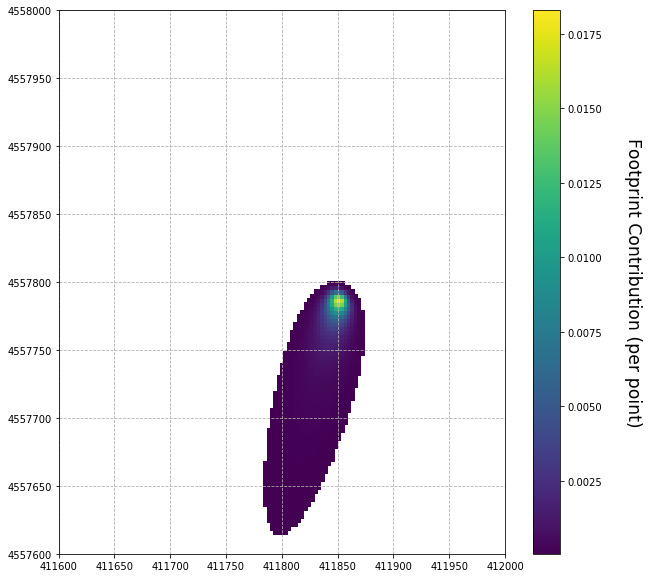

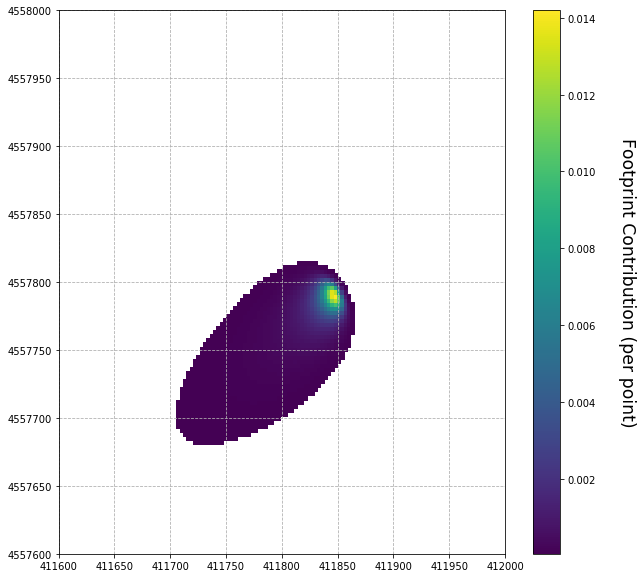

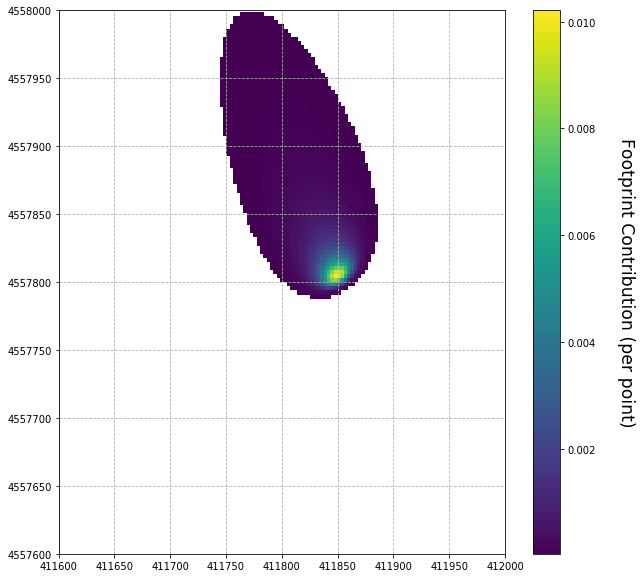

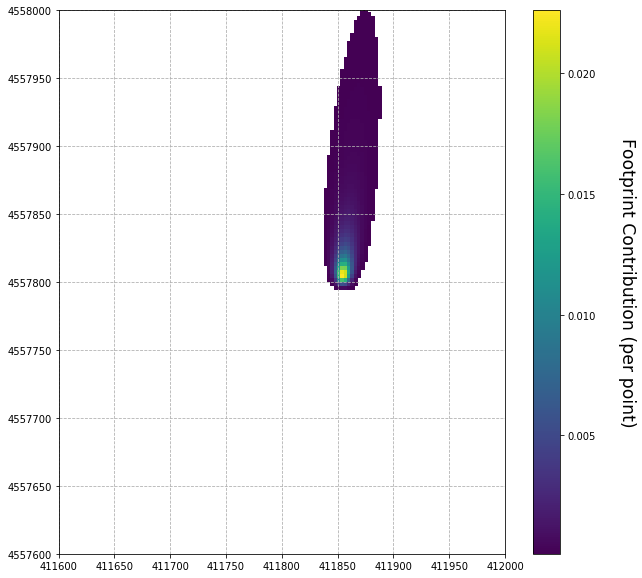

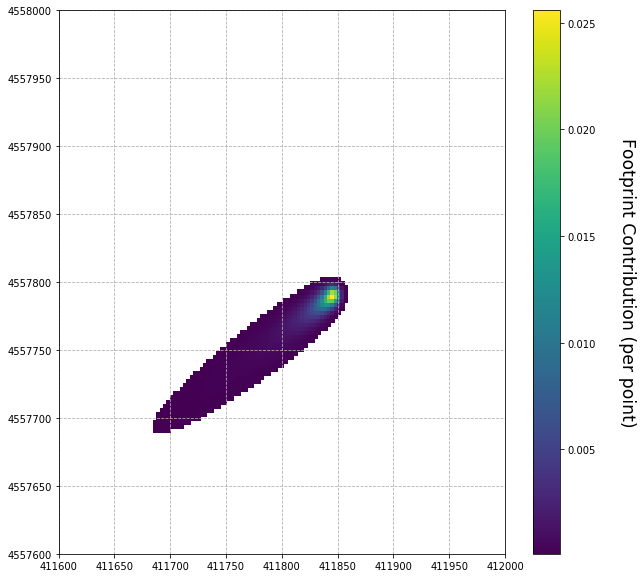

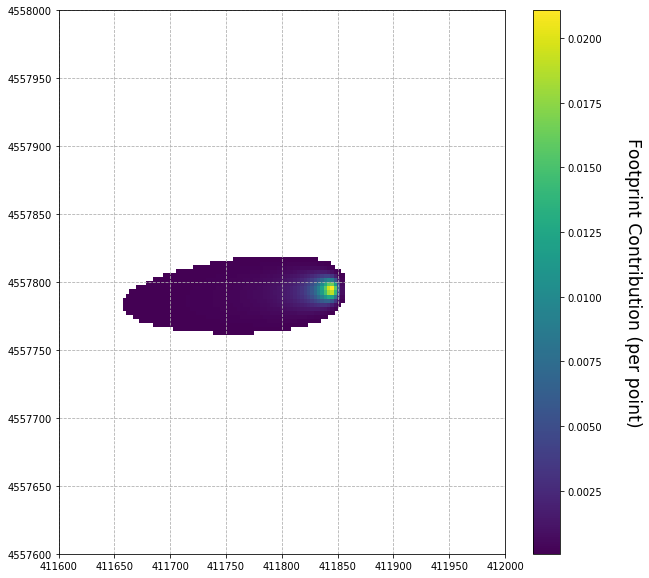

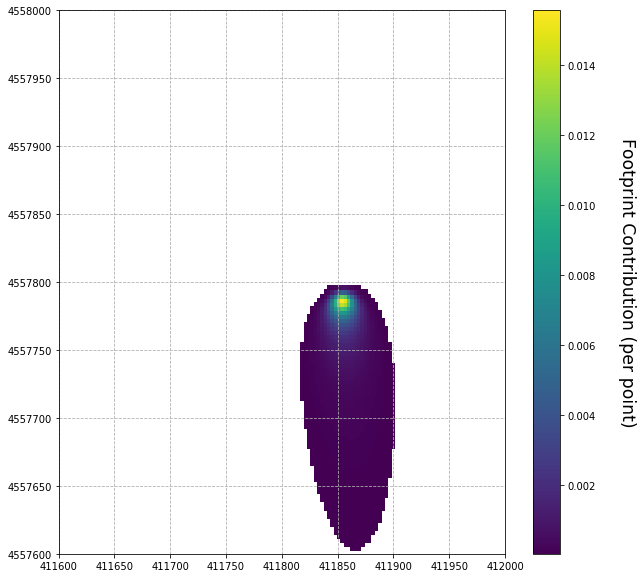

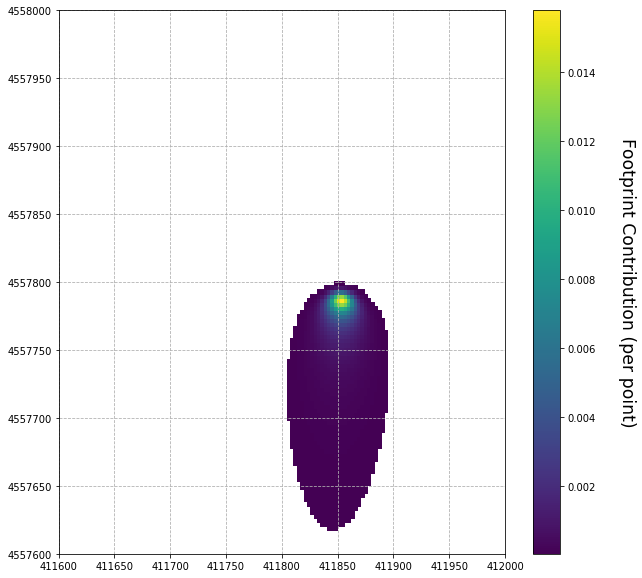

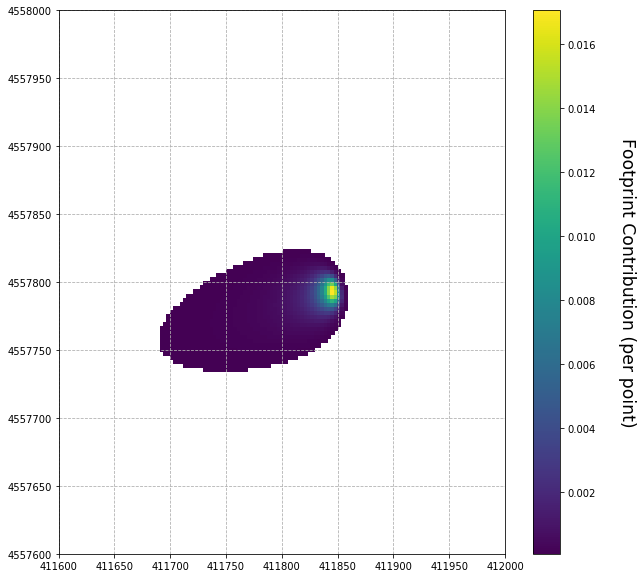

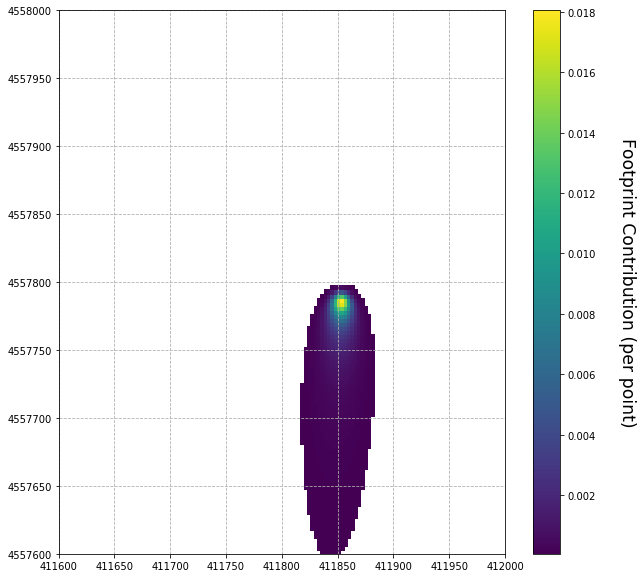

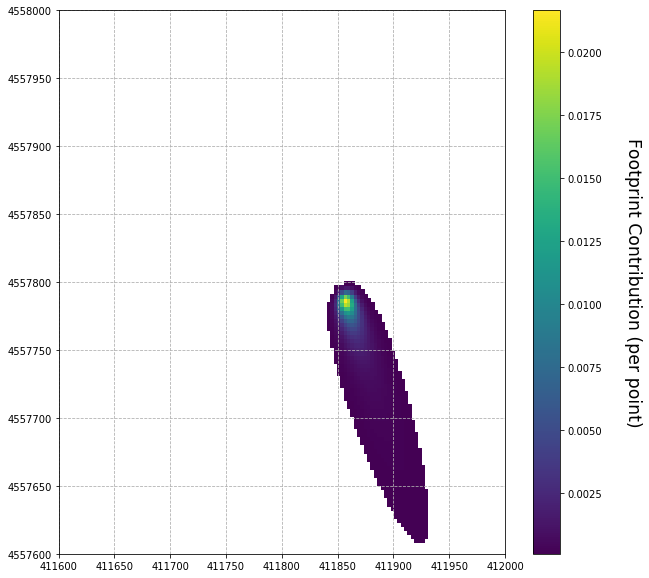

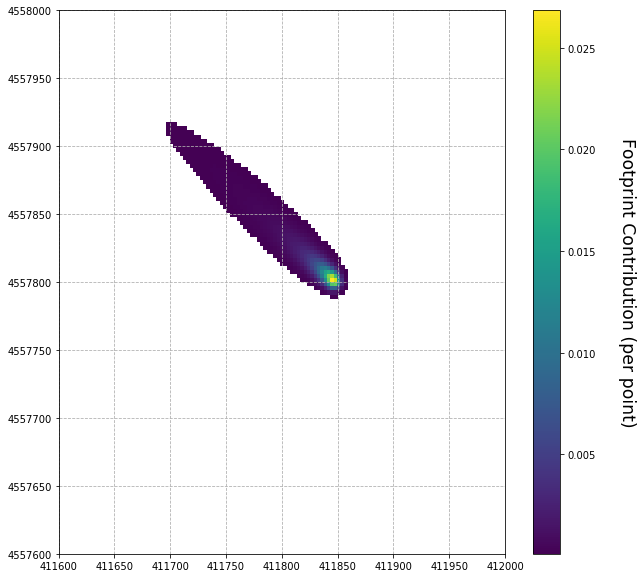

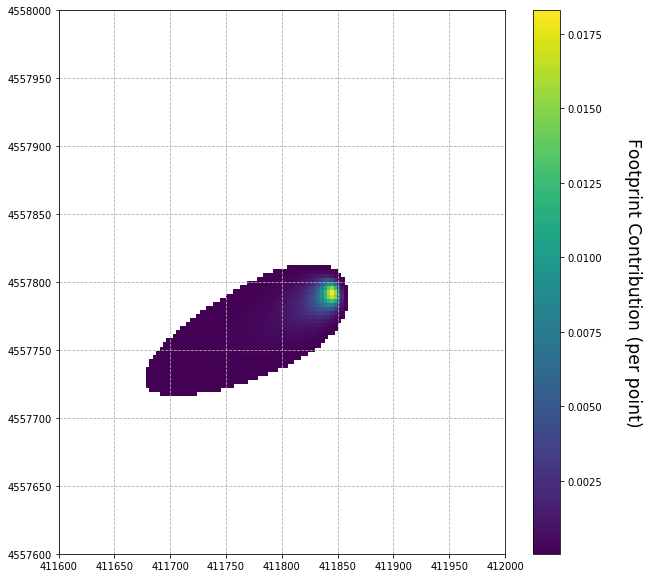

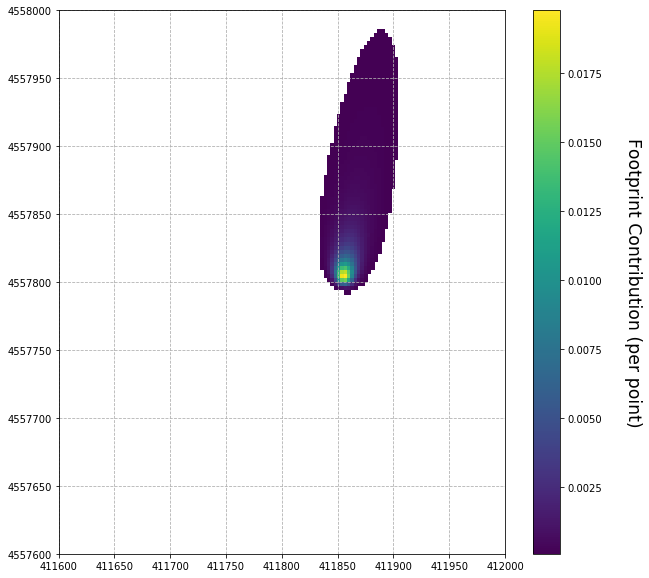

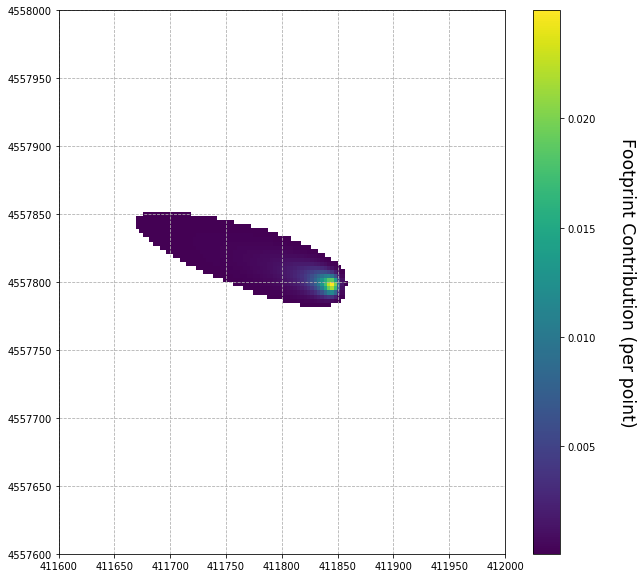

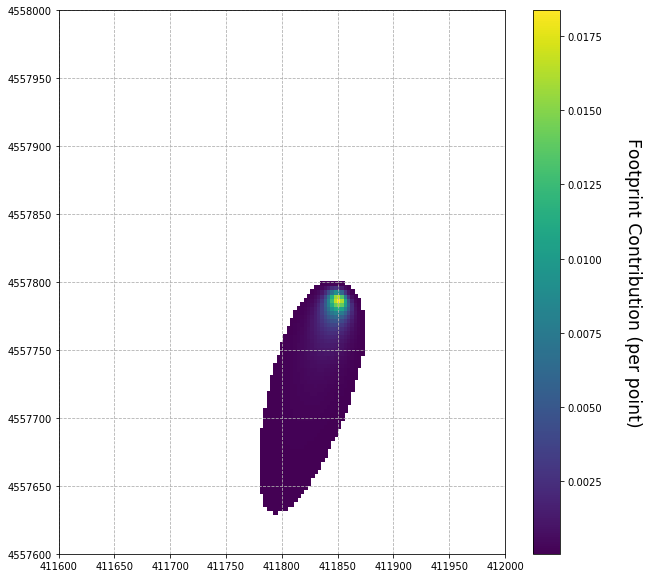

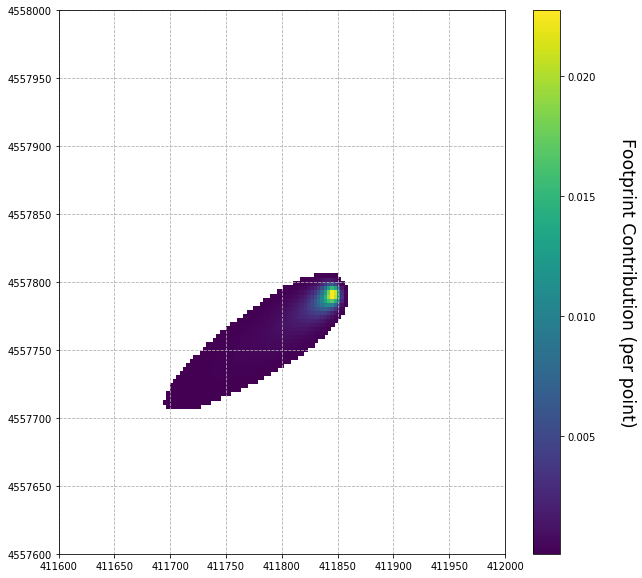

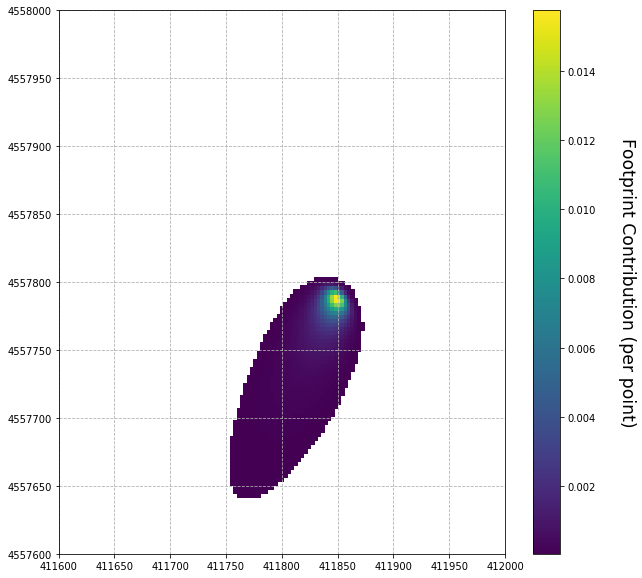

In [12]:
zm_s = 2.78
z0_s = 0.05
h_s = 2000.
full_df['ol'] = zm_s/full_df['z/L']
dx = 3.
origin_d = 600.


#Convert local coordinates to local UTM (Eagle Lake: UTM 12)
station_coord = (-112.050747,41.166695)
in_proj = proj.Proj(init='EPSG:4326')
out_proj = proj.Proj(init='EPSG:32612')
(station_x,station_y) = proj.transform(in_proj,out_proj,*station_coord)

for t in full_df.index:

    print(t)
    try:
        temp_line = full_df.loc[t,:]
        temp_nc = ls8.sel(time=t.strftime('%Y-%m-%d'))
        temp_ffp = myfootprint_s.FFP_climatology(domain=[-origin_d,origin_d,-origin_d,origin_d],dx=dx,dy=dx,
                                zm=zm_s,z0=z0_s,h=h_s,rs=None,
                                ol=temp_line['ol'],sigmav=temp_line['sig_v'],
                                ustar=temp_line['ustar'],wind_dir=temp_line['Dir'],
                                crop=0,fig=0,verbosity=0)
        
        #Calculate ckd tree of landsat images
        ls_x = temp_nc['x'].values
        ls_y = temp_nc['y'].values
        ls_xx,ls_yy = np.meshgrid(ls_x,ls_y)
        ls_xflat = ls_xx.ravel()
        ls_yflat = ls_yy.ravel()
        dummy_mask = temp_nc['EF'].values.ravel()

        combine_xy_df = pd.DataFrame({'x_ls':ls_xflat,'y_ls':ls_yflat,'ef':dummy_mask})
        combine_xy_df = combine_xy_df.dropna().reset_index()

        combine_xy = np.column_stack([combine_xy_df['x_ls'].values,combine_xy_df['y_ls'].values])

        kd_tree = scipy.spatial.cKDTree(list(combine_xy))
    
    except Exception as e:
        #print(f'Hour {hr} footprint failed, band {indx+1} not written.')
        print(e)
        continue

    f_2d = np.array(temp_ffp['fclim_2d'])
    x_2d = np.array(temp_ffp['x_2d']) + station_x
    y_2d = np.array(temp_ffp['y_2d']) + station_y
    f_2d = f_2d*dx**2

    #Mask out any values below the 90% cumulative threshold
    t_f2d = f_2d.flatten()
    df_f2d = pd.DataFrame({'f2d':t_f2d}).sort_values(by='f2d').iloc[::-1]
    fullsum = df_f2d['f2d'].sum()
    df_f2d['cumsum_f2d'] = df_f2d['f2d'].cumsum()
    gb_df_f2d = df_f2d.groupby('f2d',as_index=True).mean()
    diff = abs(gb_df_f2d['cumsum_f2d']-0.9)
    cutoff = diff.idxmin()
    f_2d = np.where(f_2d>=cutoff,f_2d,np.nan)
    fig,ax = plt.subplots(**{'figsize':(10,10)})
    fprint = ax.pcolormesh(x_2d,y_2d,f_2d)
    cbar = fig.colorbar(fprint)
    cbar.set_label(label='Footprint Contribution (per point)',fontsize='xx-large',rotation=270,labelpad=40)
    time = t.strftime('%Y-%m-%d')
    ax.grid(ls='--')
    ax.set_xlim(411600.,412000.)
    ax.set_ylim(4557600.,4558000.)
    plt.savefig(f'{time}.png',transparent=True)
    
    
    footprint_df = pd.DataFrame({'x_foot':x_2d.ravel(),'y_foot':y_2d.ravel(),'footprint':f_2d.ravel()}).dropna().reset_index()
    points = np.column_stack([footprint_df['x_foot'].values,footprint_df['y_foot'].values])
    dist,idx = kd_tree.query(list(points))
    footprint_df['x'] = combine_xy_df.loc[idx,'x_ls'].reset_index()['x_ls']
    footprint_df['y'] = combine_xy_df.loc[idx,'y_ls'].reset_index()['y_ls']
    
    weights = footprint_df.groupby(['x','y'],as_index=False).agg({'footprint':'sum'})
    
    test_weights = []
    test_efs = []
    
    for p in weights.index:
        pixel_weight = weights['footprint'][p]
        x,y = weights['x'][p],weights['y'][p]
        temp_ef = combine_xy_df[(combine_xy_df['x_ls'] == x) & (combine_xy_df['y_ls'] == y)]['ef'].values
        weighted_ef = pixel_weight*temp_ef
        test_efs.append(temp_ef)
        test_weights.append(pixel_weight)
    efs = np.array(test_efs).ravel()
    weights = np.array(test_weights).ravel()
    print(np.sum(efs*weights))




In [ ]:
print(asdf.sum())

In [198]:
weighted_all = asdf*jkl
print(np.sum(weighted_all))

0.686378502741842
